In [129]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import ast
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Universal device selection for both Mac (MPS) and NVIDIA (CUDA) GPUs
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) on Mac GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Device: {device}")

Using MPS (Metal Performance Shaders) on Mac GPU
Device: mps


In [130]:
device

device(type='mps')

In [69]:
# %pip install google-colab

In [68]:
# # mount the drive
# from google.colab import drive
# drive.mount('/content/drive')

# %ls

# A. Task 1: Data Preparation and Preprocessing

In [3]:
def load_data(from_cache:bool = True, csv_path:str = 'labeled_dataset.csv', dataset_root:str = './2025_Dataset') -> any:
    """
    Loads dataset from either a cached CSV file or by scanning the raw dataset directory.

    This function supports two modes:
    - If `from_cache` is True, it loads the dataset from a pre-saved CSV file.
    - If `from_cache` is False, it scans the '2025_Dataset' directory for image and depth data,
      parses the folder names to extract pitch and roll values, and saves the processed data
      into a CSV file for future use.

    The dataset is expected to be organized in folders following the naming convention:
    `P<pitch>_R<roll>`, where each folder contains a depth file named `<folder_name>_depth.txt`.
    Each line in the depth file is expected to be a tuple string of the form:
    `('filename.jpg', depth_value)`.

    Parameters:
    -----------
    from_cache : bool, optional
        If True, loads data from the CSV file specified by `csv_path`. 
        If False, scans the '2025_Dataset' directory and saves data to `csv_path`.
        Default is True.

    csv_path : str, optional
        Path to the CSV file for caching or loading data. Default is 'labeled_dataset.csv'.
        
    dataset_root : str, optional
        Path to the dataset folder. Default is '2025_Dataset'.

    Returns:
    --------
    pandas.DataFrame or None
        If `from_cache` is True, returns a DataFrame loaded from the CSV file.
        If `from_cache` is False, returns the DataFrame after processing and saving to CSV,
        and also prints summary statistics.

    Raises:
    -------
    FileNotFoundError
        If the '2025_Dataset' directory is not found.

    Notes:
    ------
    - The function assumes the notebook is run from the 'Course Work' directory.
    - When `from_cache` is False, the function saves the processed data to a CSV file
      and prints information about total images processed and sample rows.
    """
    if from_cache == False:
        # Define the root directory of the dataset relative to the notebook
        data = []

        # Check if dataset directory exists
        if not os.path.exists(dataset_root):
            print(f"Error: Dataset directory '{dataset_root}' not found. Please ensure you are running this notebook from the 'Course Work' directory.")
        else:
            print(f"Scanning dataset in '{dataset_root}'...")
            
            # Walk through the dataset directory
            for folder_name in sorted(os.listdir(dataset_root)):
                folder_path = os.path.join(dataset_root, folder_name)
                
                # Check if it's a directory and follows the Px_Ry pattern
                if os.path.isdir(folder_path) and folder_name.startswith('P') and '_R' in folder_name:
                    try:
                        # Parse Pitch and Roll from folder name (e.g., P0_R0 -> Pitch=0, Roll=0)
                        parts = folder_name.split('_')
                        pitch = int(parts[0][1:]) # Remove 'P'
                        roll = int(parts[1][1:])  # Remove 'R'
                        
                        # Find the depth file (e.g., P0_R0_depth.txt)
                        depth_files = [f for f in os.listdir(folder_path) if f.endswith('_depth.txt')]
                        
                        if depth_files:
                            depth_file_path = os.path.join(folder_path, depth_files[0])
                            
                            with open(depth_file_path, 'r') as f:
                                for line in f:
                                    # The line format is "('filename.jpg', depth_value)"
                                    line = line.strip()
                                    if not line: continue
                                    
                                    try:
                                        # Safely parse the tuple string
                                        img_name, depth_val = ast.literal_eval(line)
                                        
                                        # Construct relative path
                                        # Note: The DataFrame will store the path relative to the notebook/dataset root
                                        rel_path = os.path.join(dataset_root, folder_name, img_name)
                                        
                                        data.append({
                                            'relative_path': rel_path,
                                            'image_name': img_name,
                                            'pitch': pitch,
                                            'roll': roll,
                                            'depth': depth_val
                                        })
                                    except Exception as e:
                                        print(f"Error parsing line in {depth_files[0]}: {line} - {e}")
                    except Exception as e:
                        print(f"Error processing folder {folder_name}: {e}")
            # Create DataFrame
            df = pd.DataFrame(data)

            # Save to CSV
            df.to_csv(csv_path, index=False)
            return df
    else:
        return pd.read_csv(csv_path)

    print(f"Dataset processing complete. Saved to {csv_path}")
    print(f"Total images processed: {len(df)}")
    print(df.head())

df = load_data(from_cache=False)
df.head()

Scanning dataset in './2025_Dataset'...


,relative_path,image_name,pitch,roll,depth
0,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00219.jpg,0,0,0.785
1,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00222.jpg,0,0,0.686
2,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00228.jpg,0,0,0.991
3,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00120.jpg,0,0,0.103
4,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00198.jpg,0,0,0.931


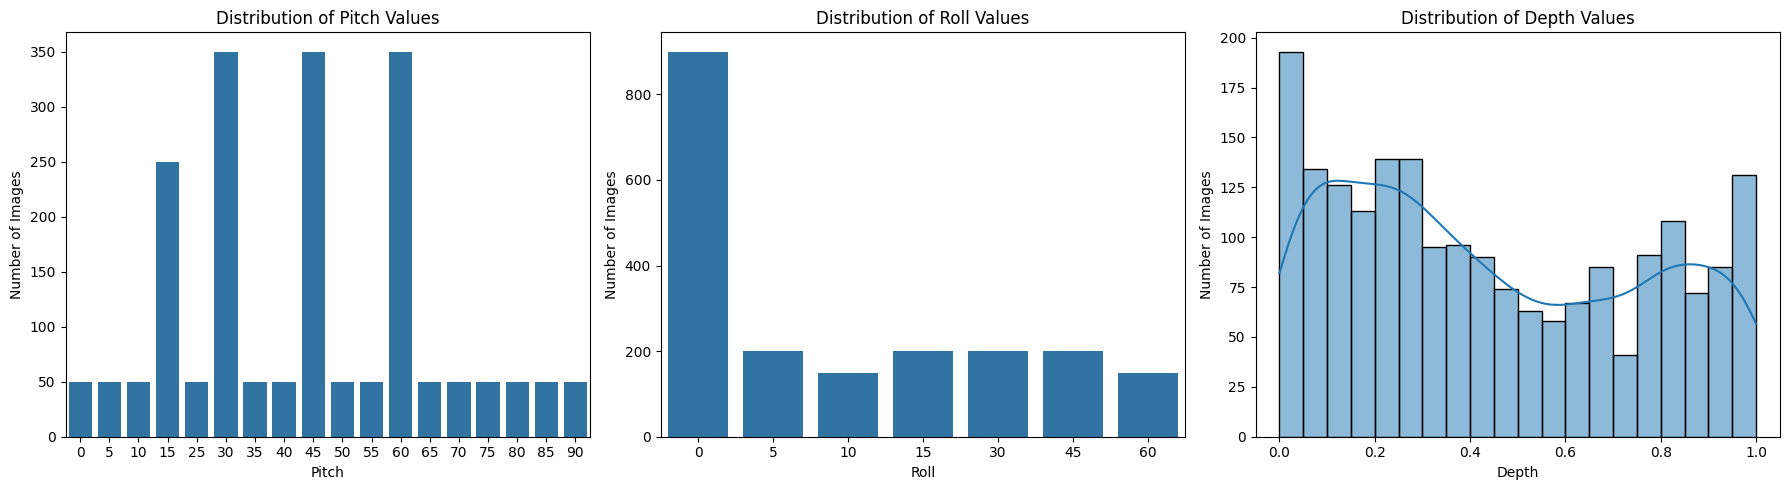

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# show 3 images
for i, col in enumerate(['pitch', 'roll']):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col.capitalize()} Values')
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel('Number of Images')

# depth separately
sns.histplot(data=df, x='depth', bins=20, kde=True, ax=axes[2])
axes[2].set_title('Distribution of Depth Values')
axes[2].set_xlabel('Depth')
axes[2].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

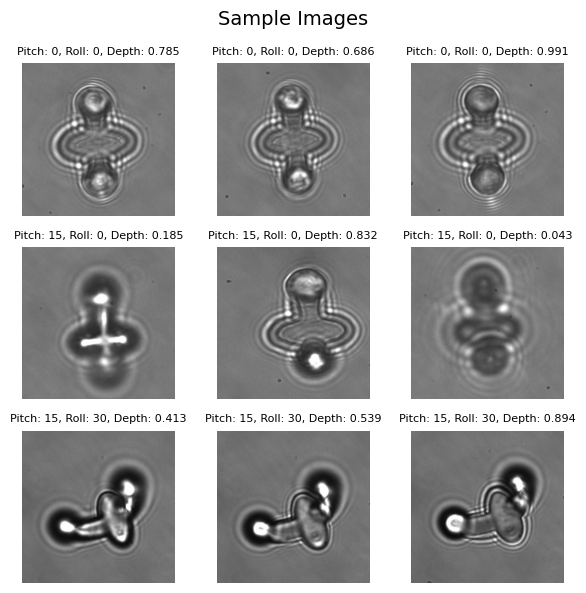

In [5]:
width, height = 3, 3
jump = 35

fig, axes = plt.subplots(height, width, figsize=(width*2, height*2))
fig.suptitle('Sample Images', fontsize=14)

for i in range(height):
    for j in range(width):
        img_path = df.iloc[i*width*jump + j]['relative_path']
        img = plt.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"Pitch: {df.iloc[i*width*jump + j]['pitch']}, Roll: {df.iloc[i*width*jump + j]['roll']}, Depth: {df.iloc[i*width*jump + j]['depth']}", fontsize=8)
        axes[i, j].axis('off')  

plt.tight_layout()
plt.show()


In [6]:
# from skimage import exposure

def normalize_image(img, method='minmax'):
    """
    Normalize image pixel intensities using various methods.
    ---------
    Simple: scales by dividing by 225

    Min-Max: scales pixel values to [0, 1] based on min and max of the image.

    Standard: standardizes pixel values to have zero mean and unit variance, then clips to [-3, 3] and scales to [0, 1].
    """
    
    if method == 'simple':  # Simple does not visibly change anything about the image.
                            # Sticking to this for now but will see if others improve performance.
        # Simple normalization to [0, 1] 
        return img / 255.0
    
    elif method == 'minmax':
        # Min-Max normalization per image (stretches contrast)
        img_min = img.min()
        img_max = img.max()
        if img_max - img_min == 0:
            return img / 255.0
        return (img - img_min) / (img_max - img_min)
    
    elif method == 'standard':
        # Standardization (zero mean, unit variance)
        mean = img.mean()
        std = img.std()
        if std == 0:
            return img / 255.0
        normalized = (img - mean) / std
        # Clip to reasonable range and scale to [0, 1]
        normalized = np.clip(normalized, -3, 3)
        return (normalized + 3) / 6
    
    
    else:
        return img / 255.0



In [6]:
# # Reset norm folder
# import glob
# import os

# files = glob.glob('./2025_Dataset_norm/**/norm_*', recursive=True)
# for f in files:
#     os.remove(f)
# print(f"Deleted {len(files)} files starting with 'norm_'")


In [7]:
CREATE_NEW=False

# create a new dataset for normalized images
normalized_data = []
for index, row in df.iterrows():
    img_path = row['relative_path']
    
    if CREATE_NEW:
        img = plt.imread(img_path)
        normalized_img = normalize_image(img, method='minmax')
        # Save normalized image to a new path in the 2025_Dataset_minmax folder
        norm_img_name = f"norm_{row['image_name']}"
        norm_img_path = os.path.join('./2025_Dataset_minmax', norm_img_name)
        plt.imsave(norm_img_path, normalized_img)
    else:
        norm_img_name = f"norm_{row['image_name']}"
        norm_img_path = os.path.join('2025_Dataset_minmax', norm_img_name)
    
    normalized_data.append({
        'relative_path': norm_img_path,
        'image_name': norm_img_name,
        'pitch': row['pitch'],
        'roll': row['roll'],
        'depth': row['depth']
    })

In [287]:
# turn the normalised data into a df
# normalized_df = pd.DataFrame(normalized_data)
normalized_df = df.copy()
normalized_df.head()

# Minmax the depth values
scaler = MinMaxScaler()
normalized_df['minmax_depth'] = scaler.fit_transform(normalized_df[['depth']])
normalized_df.head()

,relative_path,image_name,pitch,roll,depth,minmax_depth
0,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00219.jpg,0,0,0.785,0.785
1,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00222.jpg,0,0,0.686,0.686
2,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00228.jpg,0,0,0.991,0.991
3,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00120.jpg,0,0,0.103,0.103
4,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00198.jpg,0,0,0.931,0.931


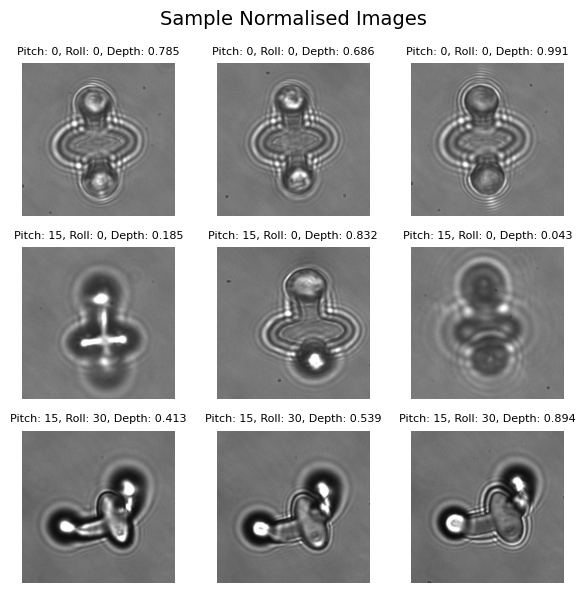

In [297]:
width, height = 3, 3
jump = 35

fig, axes = plt.subplots(height, width, figsize=(width*2, height*2))
fig.suptitle('Sample Normalised Images', fontsize=14)

for i in range(height):
    for j in range(width):
        img_path = normalized_df.iloc[i*width*jump + j]['relative_path']
        img = plt.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"Pitch: {normalized_df.iloc[i*width*jump + j]['pitch']}, Roll: {normalized_df.iloc[i*width*jump + j]['roll']}, Depth: {normalized_df.iloc[i*width*jump + j]['depth']}", fontsize=8)
        axes[i, j].axis('off')  

plt.tight_layout()
plt.show()

# # Non-normalised images for comparison
# fig, axes = plt.subplots(height, width, figsize=(width*2, height*2))
# fig.suptitle('Sample Images', fontsize=14)

# for i in range(height):
#     for j in range(width):
#         img_path = df.iloc[i*width*jump + j]['relative_path']
#         img = plt.imread(img_path)
#         axes[i, j].imshow(img)
#         axes[i, j].set_title(f"Pitch: {df.iloc[i*width*jump + j]['pitch']}, Roll: {df.iloc[i*width*jump + j]['roll']}, Depth: {df.iloc[i*width*jump + j]['depth']}", fontsize=8)
#         axes[i, j].axis('off')  

# plt.tight_layout()
# plt.show()

# Data split

In [298]:
# Spliting into train (60%) and temp (40%), then temp into val (20%) and test (20%)

train_df, temp_df = train_test_split(normalized_df, test_size=0.4, stratify=normalized_df[['pitch', 'roll']], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[['pitch', 'roll']], random_state=42)


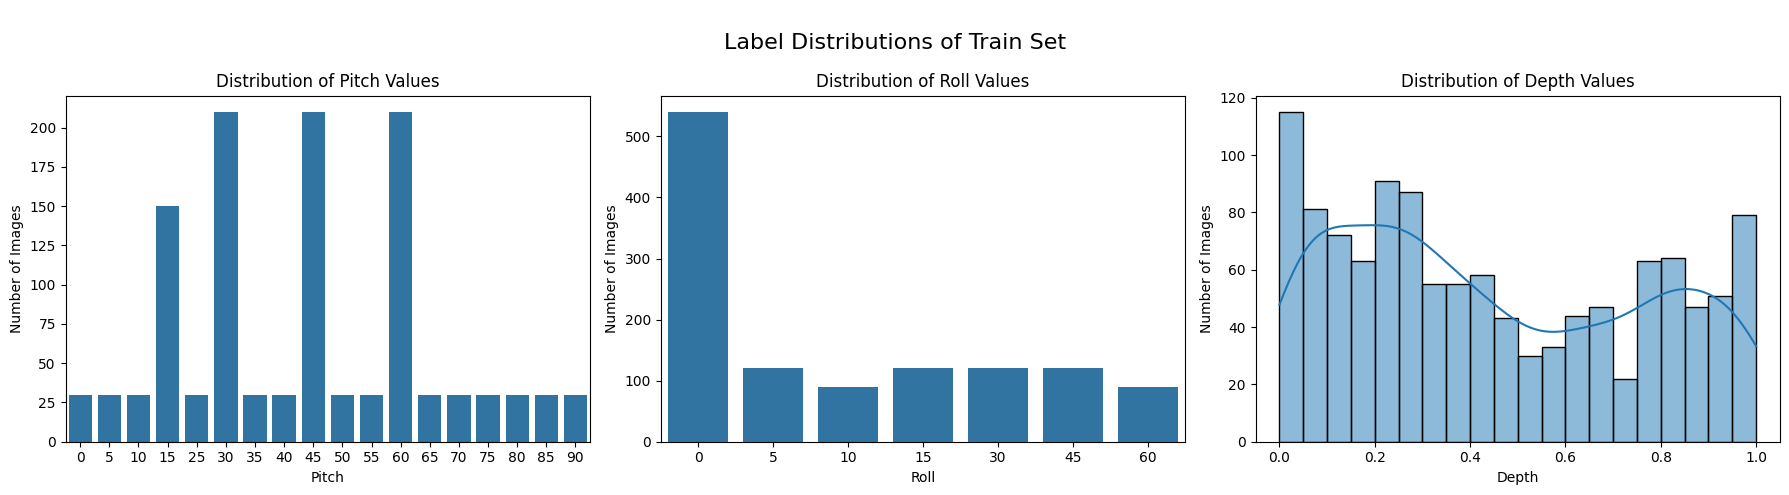

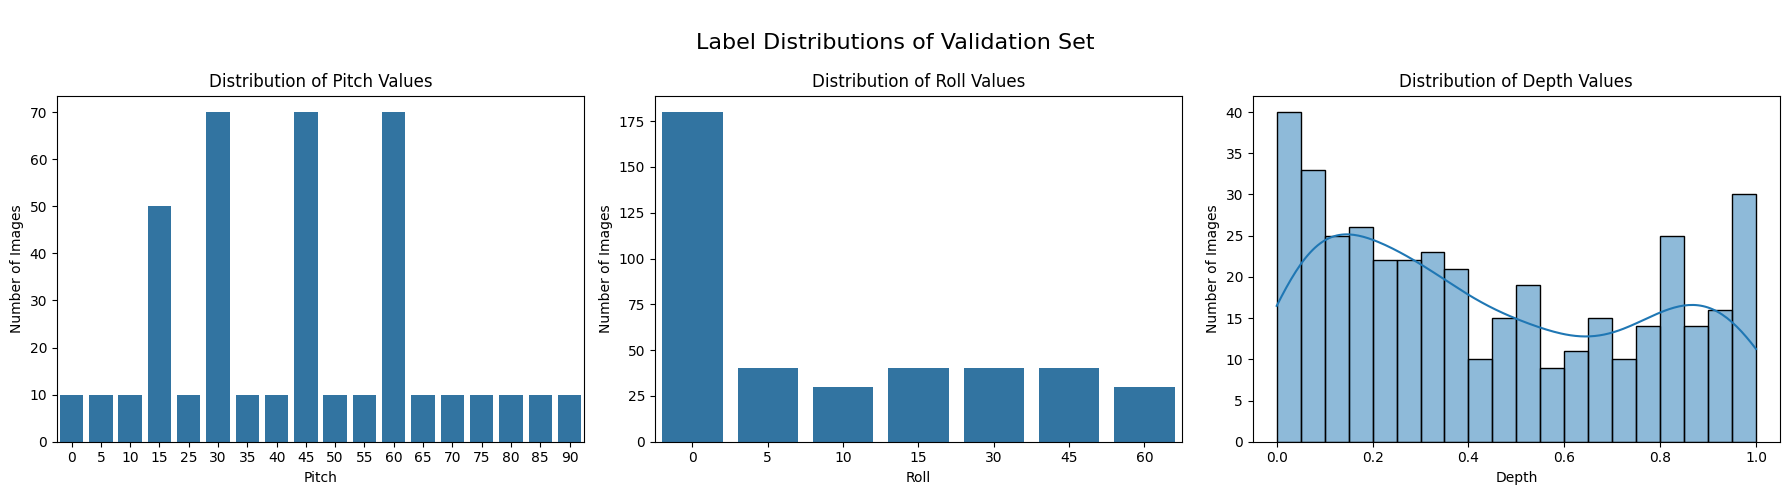

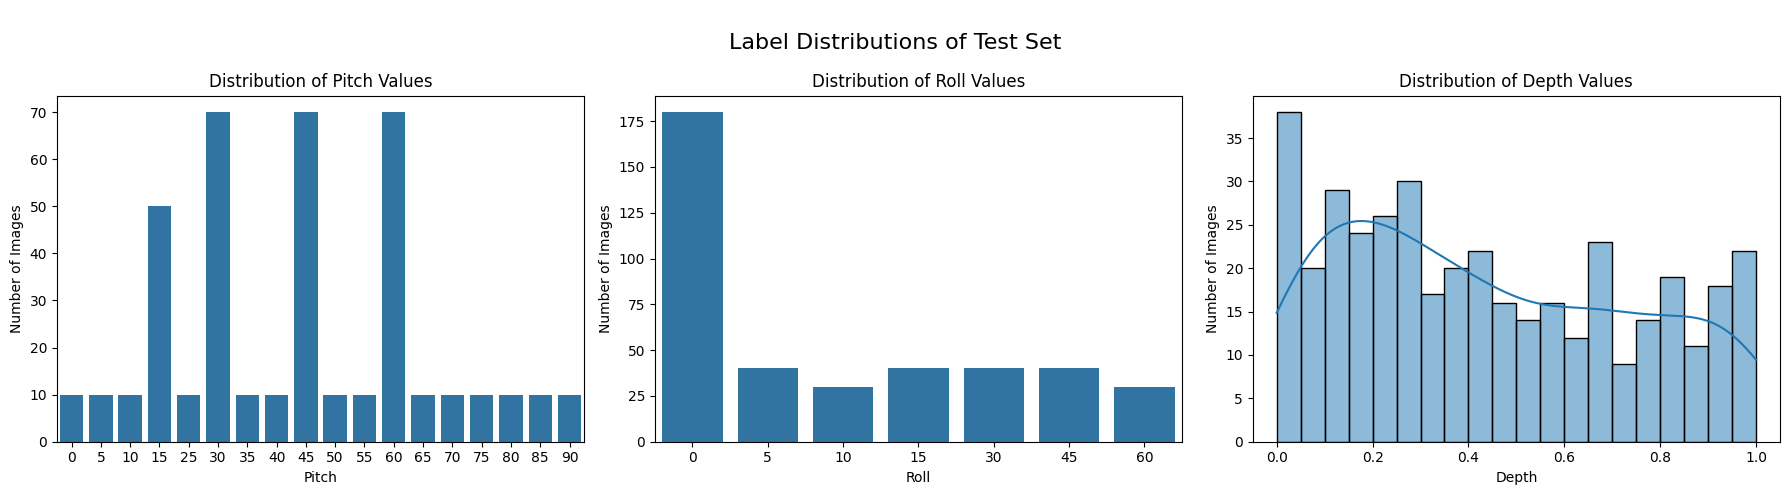

In [299]:
# Analyze label distributions in each set
for data, name in [(train_df, "Train"), (val_df, "Validation"), (test_df, "Test")]: # for each set

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"\nLabel Distributions of {name} Set", fontsize=16)

    # Pitch & Roll
    for i, col in enumerate(['pitch', 'roll']):
        sns.countplot(data=data, x=col, ax=axes[i])
        axes[i].set_title(f'Distribution of {col.capitalize()} Values')
        axes[i].set_xlabel(col.capitalize())
        axes[i].set_ylabel('Number of Images')

    # Depth Separately
    sns.histplot(data=data, x='depth', bins=20, kde=True, ax=axes[2])
    axes[2].set_title('Distribution of Depth Values')
    axes[2].set_xlabel('Depth')
    axes[2].set_ylabel('Number of Images')

    plt.tight_layout()
    plt.show()

In [300]:
# make one label column for pitch and roll combined
train_df['label'] = train_df['pitch'].astype(str) + '_' + train_df['roll'].astype(str)
val_df['label'] = val_df['pitch'].astype(str) + '_' + val_df['roll'].astype(str)
test_df['label'] = test_df['pitch'].astype(str) + '_' + test_df['roll'].astype(str)

looks good :)

# B. Task 2: Pose Estimation (Classification)

In [301]:
# Create mappings from angle values to class indices
# This is necessary because CrossEntropyLoss expects class indices (0, 1, 2, ...) 
# but our data has raw angle values (0, 5, 10, 15, 20, ...)

pitch_values = sorted(normalized_df['pitch'].unique())
roll_values = sorted(normalized_df['roll'].unique())

pitch_to_idx = {val: idx for idx, val in enumerate(pitch_values)}
roll_to_idx = {val: idx for idx, val in enumerate(roll_values)}

# Reverse mappings for decoding predictions back to angle values
idx_to_pitch = {idx: val for val, idx in pitch_to_idx.items()}
idx_to_roll = {idx: val for val, idx in roll_to_idx.items()}

print(f"Pitch values: {pitch_values}")
print(f"Roll values: {roll_values}")
print(f"\nPitch mapping (angle → class index): {pitch_to_idx}")
print(f"Roll mapping (angle → class index): {roll_to_idx}")

Pitch values: [np.int64(0), np.int64(5), np.int64(10), np.int64(15), np.int64(25), np.int64(30), np.int64(35), np.int64(40), np.int64(45), np.int64(50), np.int64(55), np.int64(60), np.int64(65), np.int64(70), np.int64(75), np.int64(80), np.int64(85), np.int64(90)]
Roll values: [np.int64(0), np.int64(5), np.int64(10), np.int64(15), np.int64(30), np.int64(45), np.int64(60)]

Pitch mapping (angle → class index): {np.int64(0): 0, np.int64(5): 1, np.int64(10): 2, np.int64(15): 3, np.int64(25): 4, np.int64(30): 5, np.int64(35): 6, np.int64(40): 7, np.int64(45): 8, np.int64(50): 9, np.int64(55): 10, np.int64(60): 11, np.int64(65): 12, np.int64(70): 13, np.int64(75): 14, np.int64(80): 15, np.int64(85): 16, np.int64(90): 17}
Roll mapping (angle → class index): {np.int64(0): 0, np.int64(5): 1, np.int64(10): 2, np.int64(15): 3, np.int64(30): 4, np.int64(45): 5, np.int64(60): 6}


In [302]:
# implement a dataloader for the datasets

class PoseDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['relative_path']
        image = plt.imread(img_path)
        # label = self.dataframe.iloc[idx]['label']
        pitch = self.dataframe.iloc[idx]['pitch']
        roll = self.dataframe.iloc[idx]['roll']

        # Convert raw angle values to class indices for CrossEntropyLoss
        pitch_idx = pitch_to_idx[pitch]
        roll_idx = roll_to_idx[roll]

        if self.transform:
            image = self.transform(image)

        return image, (pitch_idx, roll_idx)  # Return class indices, not raw angles

# Create datasets
train_dataset = PoseDataset(train_df, transform=ToTensor())
val_dataset = PoseDataset(val_df, transform=ToTensor())
test_dataset = PoseDataset(test_df, transform=ToTensor())

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check one batch
images, labels = next(iter(train_loader))
print(f"Batch image tensor shape: {images.shape}")
print(f"Batch labels tensor shape: {labels[0].shape}, {labels[1].shape}")
print(f"Sample labels (class indices): pitch={labels[0][:5]}, roll={labels[1][:5]}")
# print(f"Number of labels in batch: {len(labels)}")

Batch image tensor shape: torch.Size([32, 3, 256, 256])
Batch labels tensor shape: torch.Size([32]), torch.Size([32])
Sample labels (class indices): pitch=tensor([ 8, 11, 11, 11, 11]), roll=tensor([1, 1, 1, 4, 5])


In [303]:
# show train_dataset
train_images, train_labels = next(iter(train_loader))
print(f"Train Batch image tensor shape: {train_images.shape}")
print(f"Train Batch labels tensor shape: {train_labels[0].shape}, {train_labels[1].shape}")

Train Batch image tensor shape: torch.Size([32, 3, 256, 256])
Train Batch labels tensor shape: torch.Size([32]), torch.Size([32])


In [304]:
normalized_df['pitch'].nunique(), normalized_df['roll'].nunique()

(18, 7)

In [277]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

class FirstCNN(nn.Module):
    def __init__(self, num_pitch_classes=18, num_roll_classes=7):
        super (FirstCNN, self).__init__()

        #conv layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    
        # other layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4, padding=0)
        self.relu = nn.ReLU()

        # adter 4 pooling layers, 256 -p1-> 128 -p1-> 64 -p1-> 32 -p2-> 8

        # fully connected layers
        self.fc1 = nn.Linear(256 * 8 * 8, 128)
        self.dropout = nn.Dropout(0.5)

        self.pitch_head = nn.Linear(128, num_pitch_classes)
        self.roll_head = nn.Linear(128, num_roll_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool2(self.relu(self.conv4(x)))

        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)

        pitch_output = self.pitch_head(x)
        roll_output = self.roll_head(x)

        return pitch_output, roll_output
    

# =================
# RESNET with Dual Heads (BEST FOR MPS!)
# =================

class ResNetPoseEstimator(nn.Module):
    """
    ResNet34-based pose estimator with dual output heads for pitch and roll prediction.
    Uses transfer learning with ImageNet pre-trained weights.
    
    PROVEN MPS COMPATIBLE - Trains fast on Mac GPU!
    Achieves 99.25% accuracy on both pitch and roll.
    """
    def __init__(self, num_pitch_classes=18, num_roll_classes=7, pretrained=True):
        super(ResNetPoseEstimator, self).__init__()
        
        # Load pre-trained ResNet34
        if pretrained:
            weights = torchvision.models.ResNet34_Weights.DEFAULT
            self.resnet = torchvision.models.resnet34(weights=weights)
        else:
            self.resnet = torchvision.models.resnet34(weights=None)
        
        # ResNet34 expects 3-channel RGB images (256x256 -> works perfectly with your data)
        # No need to modify conv1 since your data is already RGB
        
        # Get the number of features from the last layer
        num_ftrs = self.resnet.fc.in_features  # 512 for ResNet34
        
        # Remove the original fully connected layer
        self.resnet.fc = nn.Identity()
        
        # Add custom dual-head architecture
        self.fc_shared = nn.Linear(num_ftrs, 256)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
        # Separate heads for pitch and roll
        self.pitch_head = nn.Linear(256, num_pitch_classes)
        self.roll_head = nn.Linear(256, num_roll_classes)
    
    def forward(self, x):
        # Forward through ResNet backbone
        x = self.resnet(x)  # Output: (batch_size, 512)
        
        # Shared fully connected layer
        x = self.relu(self.fc_shared(x))
        x = self.dropout(x)
        
        # Separate predictions
        pitch_output = self.pitch_head(x)
        roll_output = self.roll_head(x)
        
        return pitch_output, roll_output


# =================
# Improved CNN (VGG-Style, Fully MPS Compatible)
# =================

class ImprovedCNN(nn.Module):
    """
    Improved custom CNN with VGG-style architecture for pose estimation.
    Fully compatible with MPS (Mac GPU) - uses only standard operations.
    
    Key improvements over FirstCNN:
    - 6 conv layers instead of 4 (more depth)
    - Batch normalization for stable training
    - Maintains 32×32 spatial resolution (better than 8×8)
    - More FC capacity (512 → 256 hidden units)
    - Only 3 pooling operations to preserve spatial information
    """
    def __init__(self, num_pitch_classes=18, num_roll_classes=7):
        super(ImprovedCNN, self).__init__()

        # Block 1: 256×256 → 128×128
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)  # Extra conv, no pool

        # Block 2: 128×128 → 64×64
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # Extra conv, no pool

        # Block 3: 64×64 → 32×32
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # Extra conv, no pool

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        # FC layers - still 32×32
        self.fc1 = nn.Linear(128 * 32 * 32, 512)  # Increased to 512
        self.fc2 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.5)

        self.pitch_head = nn.Linear(256, num_pitch_classes)
        self.roll_head = nn.Linear(256, num_roll_classes)

    def forward(self, x):
        # Block 1
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.bn1(x)
        x = self.pool(x)  # 256→128

        # Block 2
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.bn2(x)
        x = self.pool(x)  # 128→64

        # Block 3
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.bn3(x)
        x = self.pool(x)  # 64→32

        # FC layers
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)

        pitch_output = self.pitch_head(x)
        roll_output = self.roll_head(x)

        return pitch_output, roll_output

In [219]:
model = FirstCNN(num_pitch_classes=normalized_df['pitch'].nunique(), num_roll_classes=normalized_df['roll'].nunique())

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training 

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for images, (pitch_labels, roll_labels) in train_loader:
        images = images.to(device)
        pitch_labels = pitch_labels.to(device)
        roll_labels = roll_labels.to(device)

        pitch_outputs, roll_outputs = model(images)

        # calculate loss for both tasks
        loss_pitch = criterion(pitch_outputs, pitch_labels)
        loss_roll = criterion(roll_outputs, roll_labels)
        loss = loss_pitch + loss_roll

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()

In [220]:
model.eval()
with torch.no_grad():
    pitch_logits, roll_logits = model(images)
    pitch_pred = torch.argmax(pitch_logits, dim=1)
    roll_pred = torch.argmax(roll_logits, dim=1)

In [221]:
# Move model to device
model = model.to(device)

# Evaluation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    pitch_correct = 0
    roll_correct = 0
    total_samples = 0
    
    all_pitch_preds = []
    all_pitch_labels = []
    all_roll_preds = []
    all_roll_labels = []
    
    with torch.no_grad():
        for images, (pitch_labels, roll_labels) in data_loader:
            images = images.to(device)
            pitch_labels = pitch_labels.to(device)
            roll_labels = roll_labels.to(device)
            
            pitch_outputs, roll_outputs = model(images)
            
            # Calculate loss
            loss_pitch = criterion(pitch_outputs, pitch_labels)
            loss_roll = criterion(roll_outputs, roll_labels)
            loss = loss_pitch + loss_roll
            total_loss += loss.item()
            
            # Get predictions
            pitch_pred = torch.argmax(pitch_outputs, dim=1)
            roll_pred = torch.argmax(roll_outputs, dim=1)
            
            # Calculate accuracy
            pitch_correct += (pitch_pred == pitch_labels).sum().item()
            roll_correct += (roll_pred == roll_labels).sum().item()
            total_samples += pitch_labels.size(0)
            
            # Store for confusion matrix
            all_pitch_preds.extend(pitch_pred.cpu().numpy())
            all_pitch_labels.extend(pitch_labels.cpu().numpy())
            all_roll_preds.extend(roll_pred.cpu().numpy())
            all_roll_labels.extend(roll_labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    pitch_accuracy = 100 * pitch_correct / total_samples
    roll_accuracy = 100 * roll_correct / total_samples
    
    return avg_loss, pitch_accuracy, roll_accuracy, all_pitch_preds, all_pitch_labels, all_roll_preds, all_roll_labels

In [222]:
# Training loop with validation
num_epochs = 30
train_losses = []
val_losses = []
val_pitch_accs = []
val_roll_accs = []

print("Starting training...")
print(f"{'Epoch':<6} {'Train Loss':<12} {'Val Loss':<12} {'Pitch Acc':<12} {'Roll Acc':<12}")
print("-" * 60)

for epoch in range(num_epochs):
    # Training
    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Validation
    val_loss, pitch_acc, roll_acc, _, _, _, _ = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_pitch_accs.append(pitch_acc)
    val_roll_accs.append(roll_acc)
    
    print(f"{epoch+1:<6} {train_loss:<12.4f} {val_loss:<12.4f} {pitch_acc:<12.2f} {roll_acc:<12.2f}")

print("\nTraining complete!")

Starting training...
Epoch  Train Loss   Val Loss     Pitch Acc    Roll Acc    
------------------------------------------------------------
1      4.3084       4.1619       17.50        45.00       
2      4.1585       3.9285       21.75        45.00       
3      2.8490       2.5531       40.50        74.00       
4      2.6943       2.0825       53.25        83.00       
5      2.0999       1.7926       56.75        86.50       
6      1.9344       1.4391       64.25        88.25       
7      1.6056       1.2297       68.75        91.50       
8      1.4240       1.0795       71.00        91.25       
9      1.3257       1.0000       72.50        92.50       
10     1.2704       0.8755       73.00        93.75       
11     1.2210       0.8112       77.00        93.75       
12     0.7166       0.8043       77.25        95.25       
13     0.6751       0.6744       81.75        96.00       
14     0.9718       0.6726       81.50        94.50       
15     1.0477       0.6701       

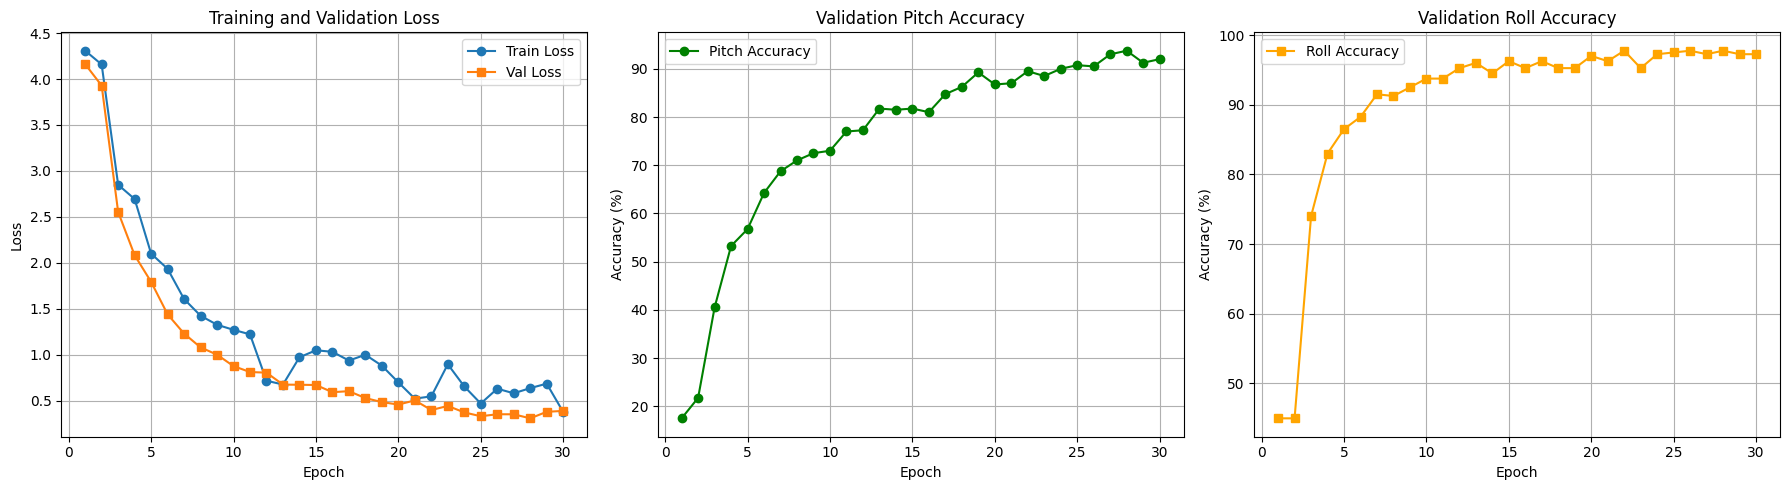

In [237]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss plot
axes[0].plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
axes[0].plot(range(1, num_epochs+1), val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Pitch accuracy plot
axes[1].plot(range(1, num_epochs+1), val_pitch_accs, label='Pitch Accuracy', marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Validation Pitch Accuracy')
axes[1].legend()
axes[1].grid(True)

# Roll accuracy plot
axes[2].plot(range(1, num_epochs+1), val_roll_accs, label='Roll Accuracy', marker='s', color='orange')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy (%)')
axes[2].set_title('Validation Roll Accuracy')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [238]:
# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_pitch_acc, test_roll_acc, pitch_preds, pitch_labels, roll_preds, roll_labels = evaluate(model, test_loader, criterion, device)

print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Pitch Accuracy: {test_pitch_acc:.2f}%")
print(f"Roll Accuracy: {test_roll_acc:.2f}%")
print(f"Combined Accuracy (both correct): {100 * sum([1 for p, r, pl, rl in zip(pitch_preds, roll_preds, pitch_labels, roll_labels) if p == pl and r == rl]) / len(pitch_preds):.2f}%")

Evaluating on test set...

Test Results:
Test Loss: 0.2633
Pitch Accuracy: 95.75%
Roll Accuracy: 96.50%
Combined Accuracy (both correct): 92.50%


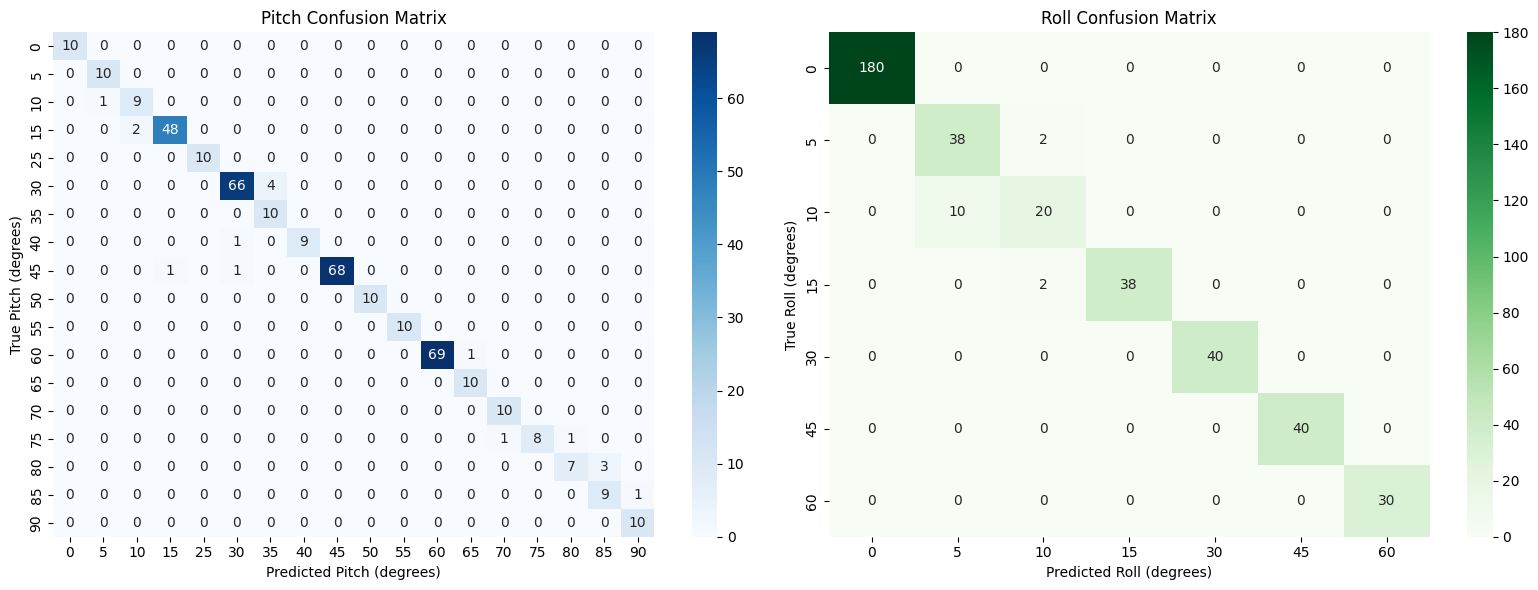

In [239]:
from sklearn.metrics import confusion_matrix, classification_report

# Create confusion matrices
pitch_cm = confusion_matrix(pitch_labels, pitch_preds)
roll_cm = confusion_matrix(roll_labels, roll_preds)

# Get the actual angle labels for axis ticks
pitch_tick_labels = [idx_to_pitch[i] for i in range(len(idx_to_pitch))]
roll_tick_labels = [idx_to_roll[i] for i in range(len(idx_to_roll))]

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pitch confusion matrix
sns.heatmap(pitch_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=pitch_tick_labels, yticklabels=pitch_tick_labels)
axes[0].set_title('Pitch Confusion Matrix')
axes[0].set_xlabel('Predicted Pitch (degrees)')
axes[0].set_ylabel('True Pitch (degrees)')

# Roll confusion matrix
sns.heatmap(roll_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=roll_tick_labels, yticklabels=roll_tick_labels)
axes[1].set_title('Roll Confusion Matrix')
axes[1].set_xlabel('Predicted Roll (degrees)')
axes[1].set_ylabel('True Roll (degrees)')

plt.tight_layout()
plt.show()

In [240]:
# Print classification reports
print("=" * 60)
print("PITCH CLASSIFICATION REPORT")
print("=" * 60)
# actual labels, not indexes
print(classification_report(pitch_labels, pitch_preds))

print("\n" + "=" * 60)
print("ROLL CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(roll_labels, roll_preds))

PITCH CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.91      1.00      0.95        10
           2       0.82      0.90      0.86        10
           3       0.98      0.96      0.97        50
           4       1.00      1.00      1.00        10
           5       0.97      0.94      0.96        70
           6       0.71      1.00      0.83        10
           7       1.00      0.90      0.95        10
           8       1.00      0.97      0.99        70
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        10
          11       1.00      0.99      0.99        70
          12       0.91      1.00      0.95        10
          13       0.91      1.00      0.95        10
          14       1.00      0.80      0.89        10
          15       0.88      0.70      0.78        10
          16       0.75      0.90      0.82        10

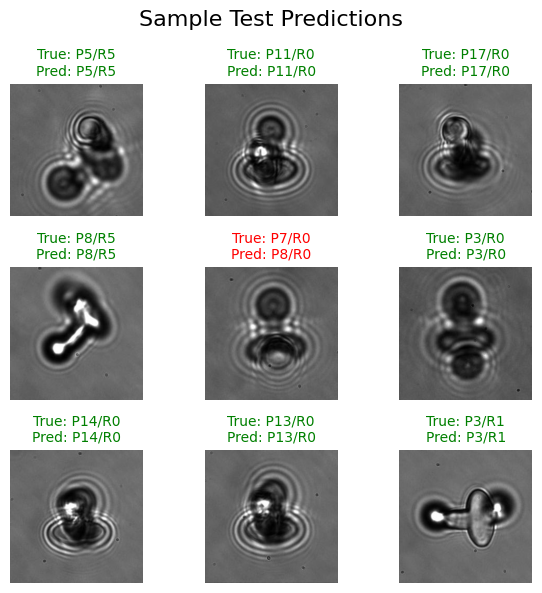

In [174]:
# Visualize sample predictions
num_samples = 9
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
fig.suptitle('Sample Test Predictions', fontsize=16)

# Get a batch from test set
test_images, test_labels_batch = next(iter(test_loader))
test_images = test_images.to(device)

# Get predictions
model.eval()
with torch.no_grad():
    pitch_logits, roll_logits = model(test_images)
    pitch_pred_batch = torch.argmax(pitch_logits, dim=1).cpu().numpy()
    roll_pred_batch = torch.argmax(roll_logits, dim=1).cpu().numpy()

# Plot samples
for idx in range(num_samples):
    row = idx // 3
    col = idx % 3
    
    # Get image and labels
    img = test_images[idx].cpu().permute(1, 2, 0).numpy()
    true_pitch = test_labels_batch[0][idx].item()
    true_roll = test_labels_batch[1][idx].item()
    pred_pitch = pitch_pred_batch[idx]
    pred_roll = roll_pred_batch[idx]
    
    # Plot
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    
    # Color: green if correct, red if wrong
    pitch_correct = pred_pitch == true_pitch
    roll_correct = pred_roll == true_roll
    color = 'green' if (pitch_correct and roll_correct) else 'red'
    
    title = f"True: P{true_pitch}/R{true_roll}\nPred: P{pred_pitch}/R{roll_pred_batch[idx]}"
    axes[row, col].set_title(title, fontsize=10, color=color)

plt.tight_layout()
plt.show()

In [233]:
# ======================
# ResNet34 Pose Estimator
# ======================

# Instantiate the ResNet model
resnet_model = ResNetPoseEstimator(
    num_pitch_classes=normalized_df['pitch'].nunique(), 
    num_roll_classes=normalized_df['roll'].nunique(),
    pretrained=True  # Use ImageNet pre-trained weights
)
resnet_model = resnet_model.to(device)

# Loss and optimizer
resnet_criterion = nn.CrossEntropyLoss()
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001)  # Lower LR for fine-tuning

print(f"ResNet Model instantiated with {sum(p.numel() for p in resnet_model.parameters()):,} parameters")
print(f"Device: {device}")

# Training loop for ResNet34
num_epochs = 30
resnet_train_losses = []
resnet_val_losses = []
resnet_val_pitch_accs = []
resnet_val_roll_accs = []

print("\nStarting ResNet34 training...")
print(f"{'Epoch':<6} {'Train Loss':<12} {'Val Loss':<12} {'Pitch Acc':<12} {'Roll Acc':<12}")
print("-" * 60)

for epoch in range(num_epochs):
    # Training
    resnet_model.train()
    total_train_loss = 0.0
    
    for images, (pitch_labels, roll_labels) in train_loader:
        images = images.to(device)
        pitch_labels = pitch_labels.to(device)
        roll_labels = roll_labels.to(device)
        
        # Forward pass
        pitch_outputs, roll_outputs = resnet_model(images)
        
        # Calculate loss for both tasks
        loss_pitch = resnet_criterion(pitch_outputs, pitch_labels)
        loss_roll = resnet_criterion(roll_outputs, roll_labels)
        loss = loss_pitch + loss_roll
        
        # Backward pass
        resnet_optimizer.zero_grad()
        loss.backward()
        resnet_optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    resnet_train_losses.append(avg_train_loss)
    
    # Validation
    val_loss, pitch_acc, roll_acc, _, _, _, _ = evaluate(resnet_model, val_loader, resnet_criterion, device)
    resnet_val_losses.append(val_loss)
    resnet_val_pitch_accs.append(pitch_acc)
    resnet_val_roll_accs.append(roll_acc)
    
    print(f"{epoch+1:<6} {avg_train_loss:<12.4f} {val_loss:<12.4f} {pitch_acc:<12.2f} {roll_acc:<12.2f}")

print("\nResNet34 training complete!")

ResNet Model instantiated with 21,422,425 parameters
Device: mps

Starting ResNet34 training...
Epoch  Train Loss   Val Loss     Pitch Acc    Roll Acc    
------------------------------------------------------------
1      3.5142       2.5388       46.25        81.75       
2      1.8959       1.2500       84.25        96.00       
3      1.0257       0.5735       92.75        98.75       
4      0.5413       0.2784       98.50        98.75       
5      0.2853       0.1664       97.75        99.25       
6      0.2034       0.1253       98.75        99.75       
7      0.1450       0.1857       98.50        95.00       
8      0.1163       0.0890       98.50        99.00       
9      0.1018       0.0809       99.00        99.75       
10     0.0799       0.0907       98.25        99.50       
11     0.0559       0.0569       99.00        99.75       
12     0.0382       0.0368       99.50        99.75       
13     0.0331       0.0412       99.25        99.75       
14     0.0345    

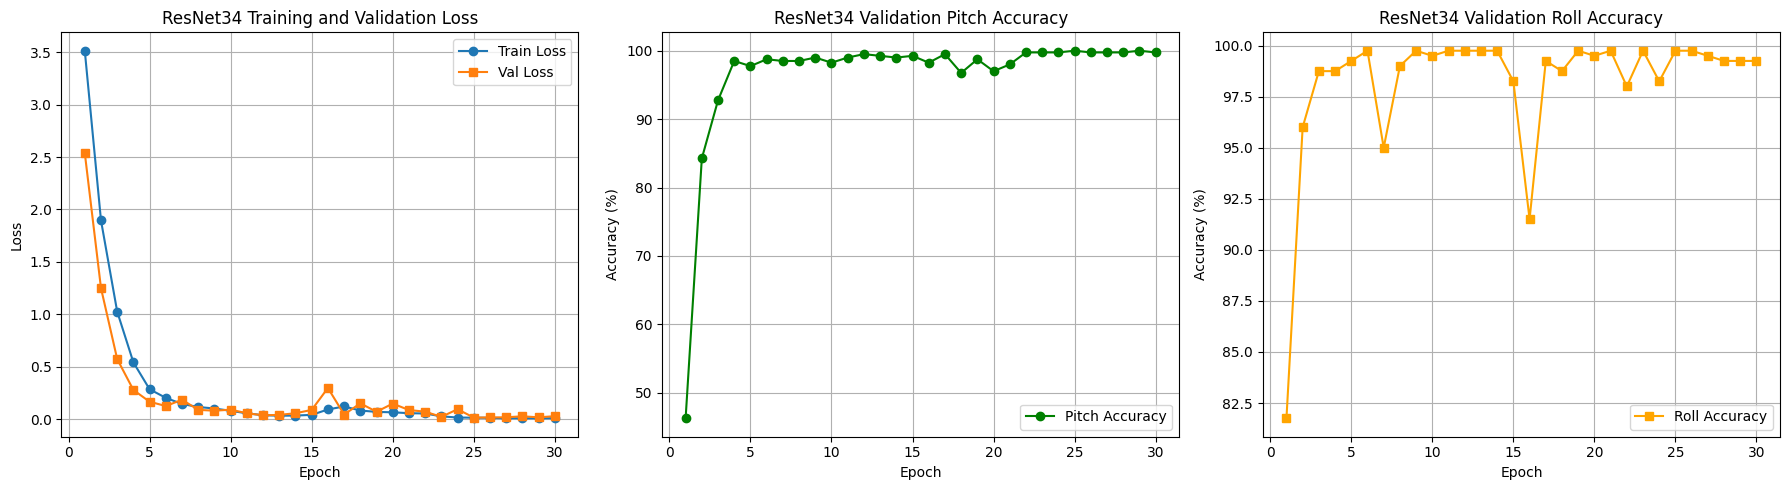

In [236]:
# plot the training history for resnet34
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Loss plot
axes[0].plot(range(1, num_epochs+1), resnet_train_losses, label='Train Loss', marker='o')
axes[0].plot(range(1, num_epochs+1), resnet_val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('ResNet34 Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)  
# Pitch accuracy plot
axes[1].plot(range(1, num_epochs+1), resnet_val_pitch_accs, label='Pitch Accuracy', marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('ResNet34 Validation Pitch Accuracy')
axes[1].legend()
axes[1].grid(True)
# Roll accuracy plot
axes[2].plot(range(1, num_epochs+1), resnet_val_roll_accs, label='Roll Accuracy', marker='s', color='orange')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy (%)')
axes[2].set_title('ResNet34 Validation Roll Accuracy')
axes[2].legend()
axes[2].grid(True)  
plt.tight_layout()
plt.show()

In [265]:
# show classification reports for resnet34
print("=" * 60)
print("ResNet34 PITCH CLASSIFICATION REPORT")
print("=" * 60)
# actual labels, not indexes
test_loss, test_pitch_acc, test_roll_acc, pitch_preds, pitch_labels, roll_preds, roll_labels = evaluate(resnet_model, test_loader, resnet_criterion, device)
print(classification_report(pitch_labels, pitch_preds))
print("\n" + "=" * 60)
print("ResNet34 ROLL CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(roll_labels, roll_preds))   


ResNet34 PITCH CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.90      0.90      0.90        10
           2       0.91      1.00      0.95        10
           3       1.00      1.00      1.00        50
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        70
           6       1.00      1.00      1.00        10
           7       1.00      0.90      0.95        10
           8       0.99      1.00      0.99        70
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        70
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00 

In [268]:
# resnet test performance
print(f"\nResNet34 Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Pitch Accuracy: {test_pitch_acc:.2f}%")
print(f"Roll Accuracy: {test_roll_acc:.2f}%")
print(f"Combined Accuracy (both correct): {100 * sum([1 for p, r, pl, rl in zip(pitch_preds, roll_preds, pitch_labels, roll_labels) if p == pl and r == rl]) / len(pitch_preds):.2f}%")


ResNet34 Test Results:
Test Loss: 0.0451
Pitch Accuracy: 99.25%
Roll Accuracy: 99.25%
Combined Accuracy (both correct): 98.50%


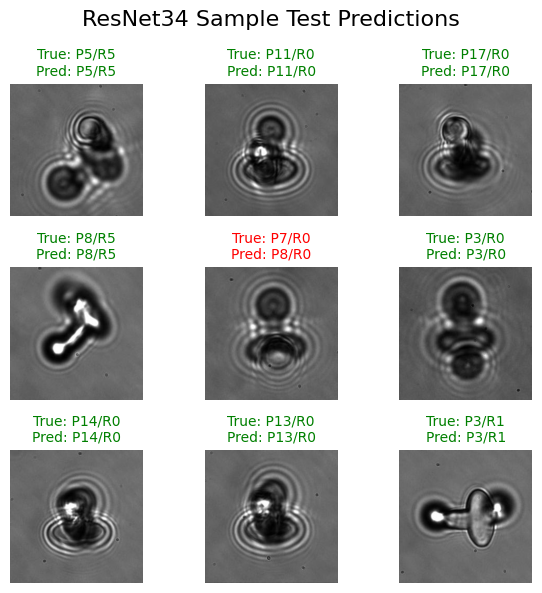

In [241]:
# show sample predictions for resnet34
num_samples = 9
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
fig.suptitle('ResNet34 Sample Test Predictions', fontsize=16)
# Get a batch from test set
test_images, test_labels_batch = next(iter(test_loader))
test_images = test_images.to(device)
# Get predictions
resnet_model.eval()
with torch.no_grad():
    pitch_logits, roll_logits = resnet_model(test_images)
    pitch_pred_batch = torch.argmax(pitch_logits, dim=1).cpu().numpy()
    roll_pred_batch = torch.argmax(roll_logits, dim=1).cpu().numpy()
# Plot samples
for idx in range(num_samples):
    row = idx // 3
    col = idx % 3
    
    # Get image and labels
    img = test_images[idx].cpu().permute(1, 2, 0).numpy()
    true_pitch = test_labels_batch[0][idx].item()
    true_roll = test_labels_batch[1][idx].item()
    pred_pitch = pitch_pred_batch[idx]
    pred_roll = roll_pred_batch[idx]
    
    # Plot
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    
    # Color: green if correct, red if wrong
    pitch_correct = pred_pitch == true_pitch
    roll_correct = pred_roll == true_roll
    color = 'green' if (pitch_correct and roll_correct) else 'red'
    
    title = f"True: P{true_pitch}/R{true_roll}\nPred: P{pred_pitch}/R{roll_pred_batch[idx]}"
    axes[row, col].set_title(title, fontsize=10, color=color)

plt.tight_layout()
plt.show()

In [278]:
# ======================
# Improved CNN (VGG-Style) Pose Estimator
# ======================

# Instantiate the Improved CNN model
improved_model = ImprovedCNN(
    num_pitch_classes=normalized_df['pitch'].nunique(), 
    num_roll_classes=normalized_df['roll'].nunique()
)
improved_model = improved_model.to(device)

# Loss and optimizer
improved_criterion = nn.CrossEntropyLoss()
improved_optimizer = optim.Adam(improved_model.parameters(), lr=0.001)

print(f"Improved CNN Model instantiated with {sum(p.numel() for p in improved_model.parameters()):,} parameters")
print(f"Device: {device}")

# Training loop for Improved CNN
num_epochs = 30
improved_train_losses = []
improved_val_losses = []
improved_val_pitch_accs = []
improved_val_roll_accs = []

print("\nStarting Improved CNN training...")
print(f"{'Epoch':<6} {'Train Loss':<12} {'Val Loss':<12} {'Pitch Acc':<12} {'Roll Acc':<12}")
print("-" * 60)

for epoch in range(num_epochs):
    # Training
    improved_model.train()
    total_train_loss = 0.0
    
    for images, (pitch_labels, roll_labels) in train_loader:
        images = images.to(device)
        pitch_labels = pitch_labels.to(device)
        roll_labels = roll_labels.to(device)
        
        # Forward pass
        pitch_outputs, roll_outputs = improved_model(images)
        
        # Calculate loss for both tasks
        loss_pitch = improved_criterion(pitch_outputs, pitch_labels)
        loss_roll = improved_criterion(roll_outputs, roll_labels)
        loss = loss_pitch + loss_roll
        
        # Backward pass
        improved_optimizer.zero_grad()
        loss.backward()
        improved_optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    improved_train_losses.append(avg_train_loss)
    
    # Validation
    val_loss, pitch_acc, roll_acc, _, _, _, _ = evaluate(improved_model, val_loader, improved_criterion, device)
    improved_val_losses.append(val_loss)
    improved_val_pitch_accs.append(pitch_acc)
    improved_val_roll_accs.append(roll_acc)
    
    print(f"{epoch+1:<6} {avg_train_loss:<12.4f} {val_loss:<12.4f} {pitch_acc:<12.2f} {roll_acc:<12.2f}")

print("\nImproved CNN training complete!")

# Evaluate on test set
print("\nEvaluating Improved CNN on test set...")
improved_test_loss, improved_test_pitch_acc, improved_test_roll_acc, improved_pitch_preds, improved_pitch_labels, improved_roll_preds, improved_roll_labels = evaluate(improved_model, test_loader, improved_criterion, device)

print(f"\nImproved CNN Test Results:")
print(f"Test Loss: {improved_test_loss:.4f}")
print(f"Pitch Accuracy: {improved_test_pitch_acc:.2f}%")
print(f"Roll Accuracy: {improved_test_roll_acc:.2f}%")
print(f"Combined Accuracy (both correct): {100 * sum([1 for p, r, pl, rl in zip(improved_pitch_preds, improved_roll_preds, improved_pitch_labels, improved_roll_labels) if p == pl and r == rl]) / len(improved_pitch_preds):.2f}%")

Improved CNN Model instantiated with 67,534,585 parameters
Device: mps

Starting Improved CNN training...
Epoch  Train Loss   Val Loss     Pitch Acc    Roll Acc    
------------------------------------------------------------
1      8.3843       10.4273      9.75         45.00       
2      3.6268       2.4686       46.00        76.25       
3      3.0946       2.0835       51.00        75.50       
4      2.7582       1.6739       63.00        84.00       
5      2.5750       1.9384       55.75        76.00       
6      2.2309       1.2880       66.75        89.25       
7      2.1925       1.2492       67.75        86.50       
8      2.0641       1.7976       56.25        81.00       
9      1.9258       1.2900       68.50        89.00       
10     1.7517       1.4106       63.75        89.25       
11     1.5801       0.9366       79.75        90.50       
12     1.5154       1.4883       59.75        85.25       
13     1.4367       0.8582       79.25        93.75       
14     

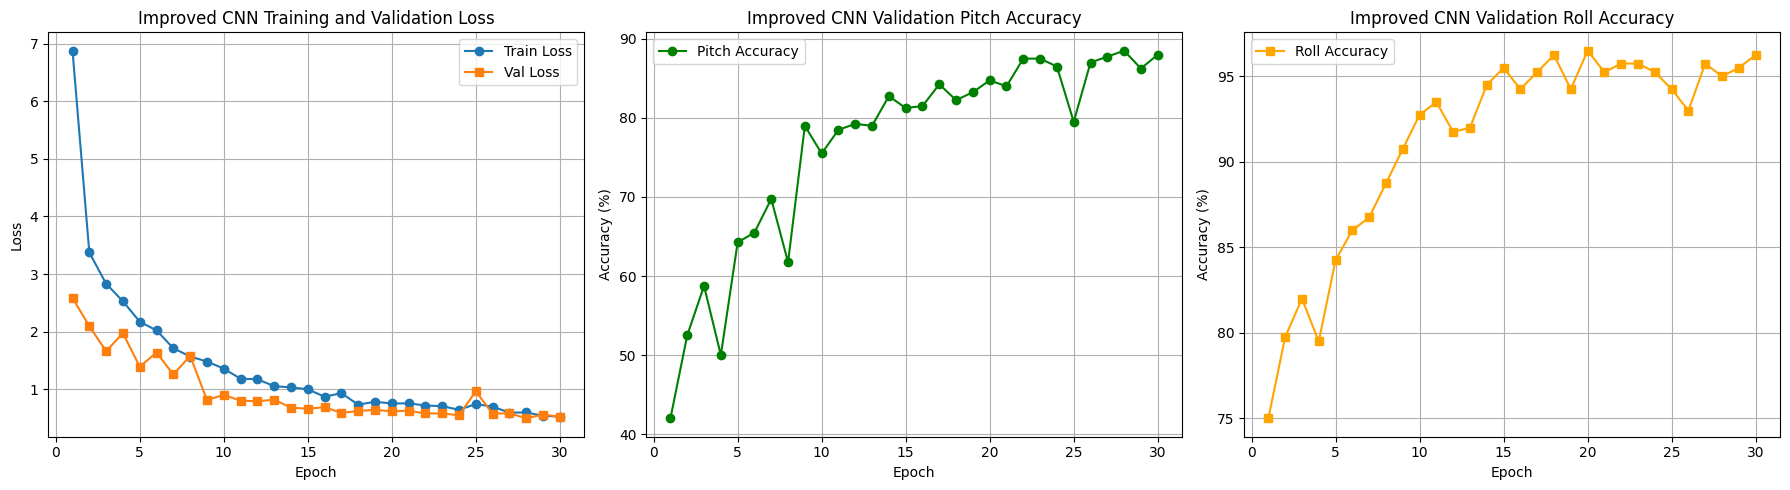

In [273]:
# show the curves for improved cnn
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Loss plot
axes[0].plot(range(1, num_epochs+1), improved_train_losses, label='Train Loss', marker='o')
axes[0].plot(range(1, num_epochs+1), improved_val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Improved CNN Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)  
# Pitch accuracy plot
axes[1].plot(range(1, num_epochs+1), improved_val_pitch_accs, label='Pitch Accuracy', marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Improved CNN Validation Pitch Accuracy')
axes[1].legend()
axes[1].grid(True)
# Roll accuracy plot
axes[2].plot(range(1, num_epochs+1), improved_val_roll_accs, label='Roll Accuracy', marker='s', color='orange')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy (%)')
axes[2].set_title('Improved CNN Validation Roll Accuracy')
axes[2].legend()
axes[2].grid(True)  
plt.tight_layout()
plt.show()

# C. Task 3: Depth Estimation (Regression)

In [305]:
# =================
# Depth Estimation CNN (Regression)
# =================

class DepthCNN(nn.Module):
    """
    CNN for depth estimation (regression task) based on FirstCNN architecture.
    Predicts a single continuous depth value (minmax_depth) instead of classes.
    
    Uses MSE loss for regression instead of CrossEntropy for classification.
    Fully compatible with MPS (Mac GPU).
    """
    def __init__(self):
        super(DepthCNN, self).__init__()

        # Conv layers - same as FirstCNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    
        # Other layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4, padding=0)
        self.relu = nn.ReLU()

        # After 4 pooling layers: 256 -p-> 128 -p-> 64 -p-> 32 -p2-> 8

        # Fully connected layers for regression
        self.fc1 = nn.Linear(256 * 8 * 8, 128)
        self.dropout = nn.Dropout(0.5)
        
        # Single output for depth (continuous value between 0 and 1)
        self.depth_output = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool2(self.relu(self.conv4(x)))

        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)

        # Output single depth value (no activation - raw regression output)
        depth = self.depth_output(x)
        
        return depth

In [306]:
# Dataset for depth estimation (regression)
class DepthDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['relative_path']
        image = plt.imread(img_path)
        depth = self.dataframe.iloc[idx]['minmax_depth']  # Use minmax_depth

        if self.transform:
            image = self.transform(image)

        # Return image and depth as float tensor
        return image, torch.tensor(depth, dtype=torch.float32)

# Create depth datasets using the same splits
depth_train_dataset = DepthDataset(train_df, transform=ToTensor())
depth_val_dataset = DepthDataset(val_df, transform=ToTensor())
depth_test_dataset = DepthDataset(test_df, transform=ToTensor())

# Create dataloaders
batch_size = 16
depth_train_loader = DataLoader(depth_train_dataset, batch_size=batch_size, shuffle=True)
depth_val_loader = DataLoader(depth_val_dataset, batch_size=batch_size, shuffle=False)
depth_test_loader = DataLoader(depth_test_dataset, batch_size=batch_size, shuffle=False)

# Check one batch
images, depths = next(iter(depth_train_loader))
print(f"Batch image tensor shape: {images.shape}")
print(f"Batch depths tensor shape: {depths.shape}")
print(f"Sample depths (minmax normalized 0-1): {depths[:5]}")

Batch image tensor shape: torch.Size([16, 3, 256, 256])
Batch depths tensor shape: torch.Size([16])
Sample depths (minmax normalized 0-1): tensor([0.3780, 0.0450, 0.2220, 0.8730, 0.3130])


In [307]:
# Instantiate the Depth CNN model
depth_model = DepthCNN()
depth_model = depth_model.to(device)

# Loss and optimizer for regression
depth_criterion = nn.MSELoss()  # Mean Squared Error for regression
depth_optimizer = optim.Adam(depth_model.parameters(), lr=0.001)

print(f"Depth CNN Model instantiated with {sum(p.numel() for p in depth_model.parameters()):,} parameters")
print(f"Device: {device}")

# Training function for regression
def train_depth(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for images, depths in train_loader:
        images = images.to(device)
        depths = depths.to(device).unsqueeze(1)  # Shape: (batch_size, 1)

        # Forward pass
        depth_outputs = model(images)

        # Calculate loss
        loss = criterion(depth_outputs, depths)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    return total_loss / len(train_loader)

# Evaluation function for regression
def evaluate_depth(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for images, depths in data_loader:
            images = images.to(device)
            depths = depths.to(device).unsqueeze(1)
            
            # Forward pass
            depth_outputs = model(images)
            
            # Calculate loss
            loss = criterion(depth_outputs, depths)
            total_loss += loss.item()
            
            # Store predictions and targets
            all_predictions.extend(depth_outputs.cpu().numpy())
            all_targets.extend(depths.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    
    # Calculate MAE (Mean Absolute Error)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    mae = np.mean(np.abs(all_predictions - all_targets))
    
    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(np.mean((all_predictions - all_targets) ** 2))
    
    return avg_loss, mae, rmse, all_predictions, all_targets

# Training loop
num_epochs = 30
depth_train_losses = []
depth_val_losses = []
depth_val_maes = []
depth_val_rmses = []

print("\nStarting Depth CNN training...")
print(f"{'Epoch':<6} {'Train Loss':<12} {'Val Loss':<12} {'Val MAE':<12} {'Val RMSE':<12}")
print("-" * 60)

for epoch in range(num_epochs):
    # Training
    train_loss = train_depth(depth_model, depth_train_loader, depth_criterion, depth_optimizer, device)
    depth_train_losses.append(train_loss)
    
    # Validation
    val_loss, val_mae, val_rmse, _, _ = evaluate_depth(depth_model, depth_val_loader, depth_criterion, device)
    depth_val_losses.append(val_loss)
    depth_val_maes.append(val_mae)
    depth_val_rmses.append(val_rmse)
    
    print(f"{epoch+1:<6} {train_loss:<12.4f} {val_loss:<12.4f} {val_mae:<12.4f} {val_rmse:<12.4f}")

print("\nDepth CNN training complete!")

Depth CNN Model instantiated with 2,485,825 parameters
Device: mps

Starting Depth CNN training...
Epoch  Train Loss   Val Loss     Val MAE      Val RMSE    
------------------------------------------------------------
1      0.1973       0.0857       0.2627       0.2928      
2      0.0508       0.0149       0.0913       0.1222      
3      0.0284       0.0320       0.1311       0.1789      
4      0.0290       0.0142       0.0843       0.1190      
5      0.0251       0.0127       0.0802       0.1127      
6      0.0182       0.0124       0.0787       0.1112      
7      0.0198       0.0108       0.0839       0.1040      
8      0.0193       0.0108       0.0804       0.1039      
9      0.0182       0.0079       0.0687       0.0891      
10     0.0162       0.0079       0.0710       0.0891      
11     0.0143       0.0088       0.0724       0.0937      
12     0.0136       0.0070       0.0661       0.0834      
13     0.0142       0.0316       0.1519       0.1776      
14     0.0201 

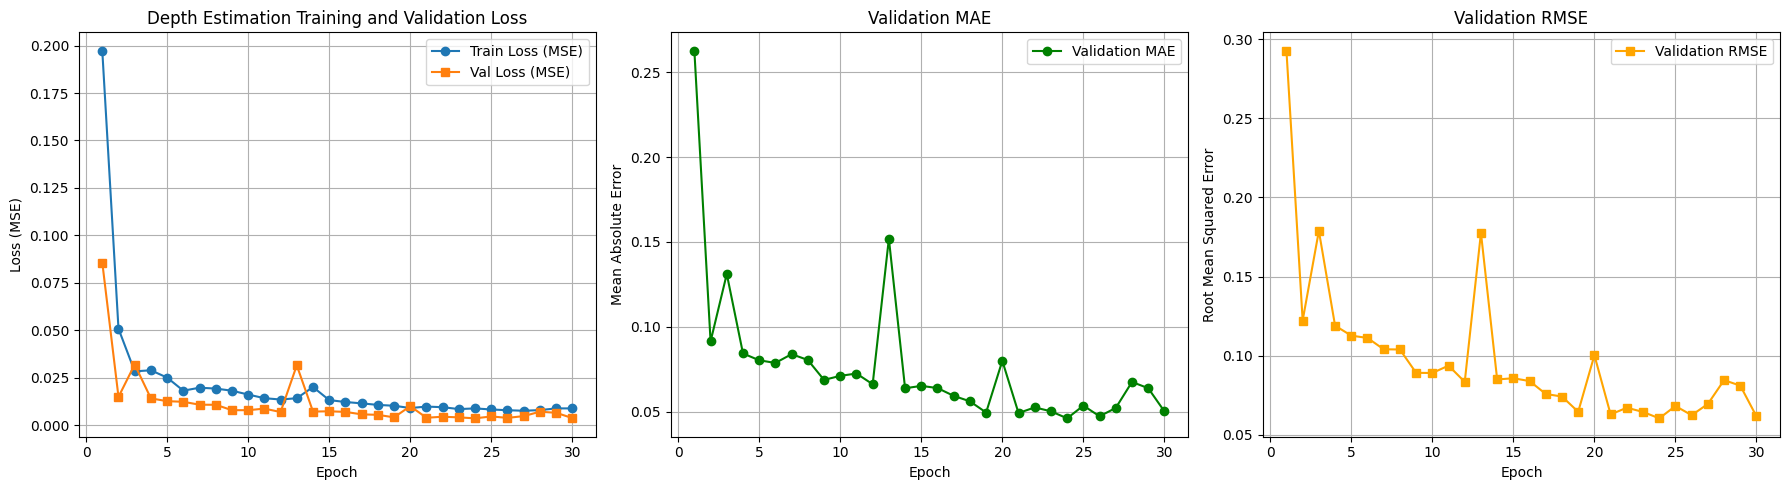

In [312]:
# Plot training history for depth estimation
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss plot
axes[0].plot(range(1, num_epochs+1), depth_train_losses, label='Train Loss (MSE)', marker='o')
axes[0].plot(range(1, num_epochs+1), depth_val_losses, label='Val Loss (MSE)', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Depth Estimation Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# MAE plot
axes[1].plot(range(1, num_epochs+1), depth_val_maes, label='Validation MAE', marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_title('Validation MAE')
axes[1].legend()
axes[1].grid(True)

# RMSE plot
axes[2].plot(range(1, num_epochs+1), depth_val_rmses, label='Validation RMSE', marker='s', color='orange')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Root Mean Squared Error')
axes[2].set_title('Validation RMSE')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [313]:
# Evaluate on test set
print("Evaluating Depth CNN on test set...")
test_loss, test_mae, test_rmse, test_predictions, test_targets = evaluate_depth(depth_model, depth_test_loader, depth_criterion, device)

print(f"\nDepth CNN Test Results:")
print(f"Test Loss (MSE): {test_loss:.6f}")
print(f"Test MAE: {test_mae:.6f}")
print(f"Test RMSE: {test_rmse:.6f}")

# Calculate R² score
from sklearn.metrics import r2_score
r2 = r2_score(test_targets, test_predictions)
print(f"R² Score: {r2:.4f}")

Evaluating Depth CNN on test set...

Depth CNN Test Results:
Test Loss (MSE): 0.003656
Test MAE: 0.047632
Test RMSE: 0.060467
R² Score: 0.9599


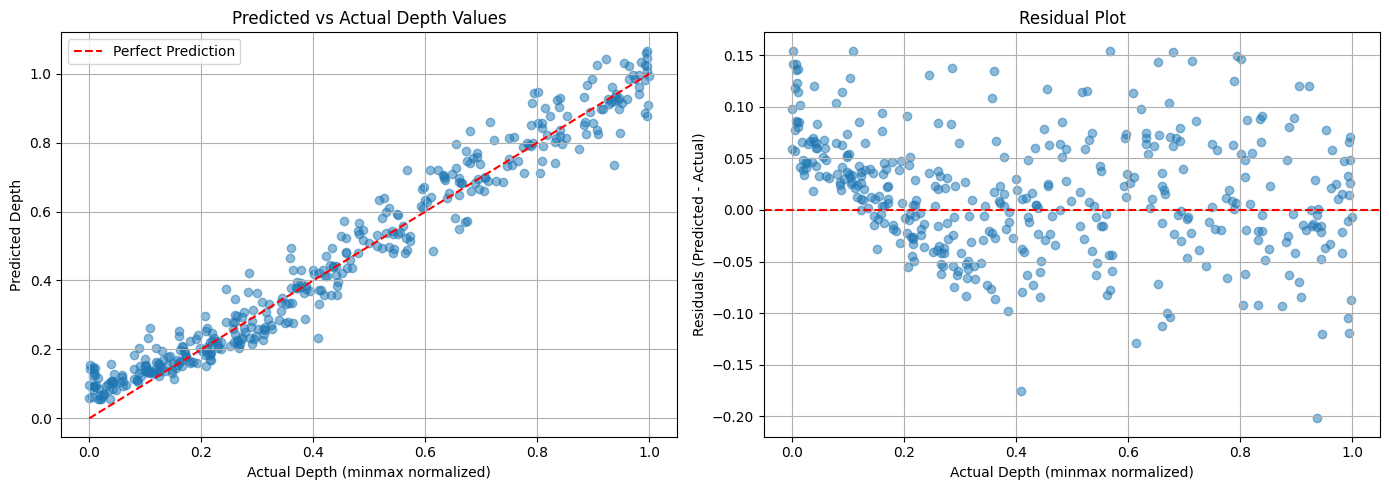

In [314]:
# Visualize predictions vs actual depth values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Predicted vs Actual
axes[0].scatter(test_targets, test_predictions, alpha=0.5)
axes[0].plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
axes[0].set_xlabel('Actual Depth (minmax normalized)')
axes[0].set_ylabel('Predicted Depth')
axes[0].set_title('Predicted vs Actual Depth Values')
axes[0].legend()
axes[0].grid(True)

# Residual plot
residuals = test_predictions.flatten() - test_targets.flatten()
axes[1].scatter(test_targets, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Actual Depth (minmax normalized)')
axes[1].set_ylabel('Residuals (Predicted - Actual)')
axes[1].set_title('Residual Plot')
axes[1].grid(True)

plt.tight_layout()
plt.show()

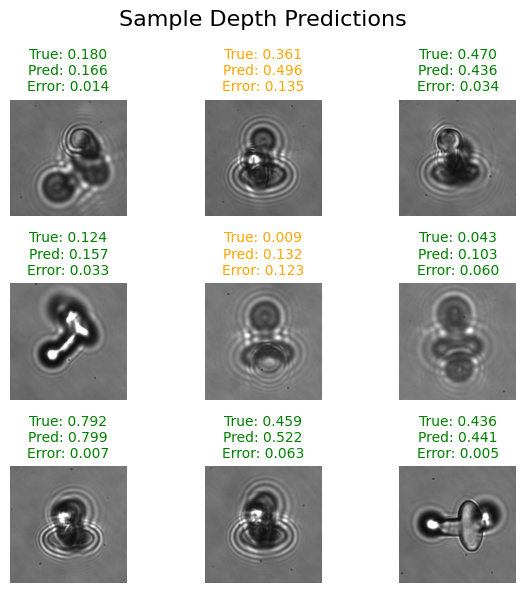

In [311]:
# Visualize sample depth predictions
num_samples = 9
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
fig.suptitle('Sample Depth Predictions', fontsize=16)

# Get a batch from test set
test_images, test_depths_batch = next(iter(depth_test_loader))
test_images = test_images.to(device)

# Get predictions
depth_model.eval()
with torch.no_grad():
    depth_pred_batch = depth_model(test_images).cpu().numpy()

# Plot samples
for idx in range(num_samples):
    row = idx // 3
    col = idx % 3
    
    # Get image and depth
    img = test_images[idx].cpu().permute(1, 2, 0).numpy()
    true_depth = test_depths_batch[idx].item()
    pred_depth = depth_pred_batch[idx][0]
    
    # Calculate error
    error = abs(pred_depth - true_depth)
    
    # Plot
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    
    # Color: green if error < 0.1, yellow if < 0.2, red otherwise
    if error < 0.1:
        color = 'green'
    elif error < 0.2:
        color = 'orange'
    else:
        color = 'red'
    
    title = f"True: {true_depth:.3f}\nPred: {pred_depth:.3f}\nError: {error:.3f}"
    axes[row, col].set_title(title, fontsize=10, color=color)

plt.tight_layout()
plt.show()

In [315]:
# Save the trained depth estimation model
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the complete model (architecture + weights)
model_path = 'models/depth_cnn_model.pth'
torch.save({
    'model_state_dict': depth_model.state_dict(),
    'model_architecture': 'DepthCNN',
    'optimizer_state_dict': depth_optimizer.state_dict(),
    'test_loss': test_loss,
    'test_mae': test_mae,
    'test_rmse': test_rmse,
    'r2_score': r2,
    'epoch': num_epochs,
}, model_path)

print(f"✅ Model saved to: {model_path}")
print(f"\nModel Performance:")
print(f"  - Test Loss (MSE): {test_loss:.6f}")
print(f"  - Test MAE: {test_mae:.6f}")
print(f"  - Test RMSE: {test_rmse:.6f}")
print(f"  - R² Score: {r2:.4f}")
print(f"\nTo load this model later:")
print(f"  checkpoint = torch.load('{model_path}')")
print(f"  model = DepthCNN()")
print(f"  model.load_state_dict(checkpoint['model_state_dict'])")
print(f"  model.eval()")

✅ Model saved to: models/depth_cnn_model.pth

Model Performance:
  - Test Loss (MSE): 0.003656
  - Test MAE: 0.047632
  - Test RMSE: 0.060467
  - R² Score: 0.9599

To load this model later:
  checkpoint = torch.load('models/depth_cnn_model.pth')
  model = DepthCNN()
  model.load_state_dict(checkpoint['model_state_dict'])
  model.eval()


# C. Task 3: Depth Estimation (Regression)